# Brevitas 量化神经网络
量化网络加速训练，但由于lenet网络很小，量化处理反而加长训练时间
Brevitas is a PyTorch research library for quantization-aware training (QAT).
@software{brevitas,
  author       = {Alessandro Pappalardo},
  title        = {Xilinx/brevitas},
  year         = {2021},
  publisher    = {Zenodo},
  doi          = {10.5281/zenodo.3333552},
  url          = {https://doi.org/10.5281/zenodo.3333552}
}

# 导入张量库
张量如同数组和矩阵一样, 是一种特殊的数据结构。在PyTorch中, 神经网络的输入、输出以及网络的参数等数据, 都是使用张量来进行描述。


In [1]:
import torch
import onnx 
import onnxoptimizer
import torch.nn.functional as F
import torch.optim.lr_scheduler as StepLR
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

# Low-precision integer-only LeNet

we decide to quantize activations to 4 bits and biases to 8 bits. In order to do so, we replace torch.nn.ReLU with brevitas.nn.QuantReLU, specifying bit_width=4. For bias quantization, we import the 8-bit bias quantizer Int8Bias from brevitas.quant and set it appropriately. Additionally, in order to quantize the very first input, we introduce a brevitas.nn.QuantIdentity at the beginning of the network. The end result is the following:

In [2]:
show = transforms.ToPILImage()



from torch.nn import Module
import torch.nn.functional as F

import brevitas.nn as qnn  #qnn 是 finn 的自带库 brevitas 下的类
from brevitas.quant import Int8Bias as BiasQuant

#卷积层用torch.nn.Conv2d来构建，激活层使用torch.nn.ReLU来构建，池化层使用torch.nn.MaxPool2d来构建，全连接层使用torch.nn.Linear来构建(此处量化torch.nn换为brevitas.nn.Quant)
class LowPrecisionLeNet(Module):#自定义的LowPrecisionLeNet神经网络必须从module继承
    def __init__(self):#初始化父类
        super(LowPrecisionLeNet, self).__init__()  #初始化父类
        self.quant_inp = qnn.QuantIdentity(
            bit_width=4, return_quant_tensor=True) #quantize activation to 4 bits,in order to quantize the very first input, we introduce a brevitas.nn.QuantIdentity at the beginning of the network
        self.conv1 = qnn.QuantConv2d(
            1, 6, 5, weight_bit_width=3, bias_quant=BiasQuant, return_quant_tensor=True,stride=1,padding=2)  # 1 input image channel, 6 output channels（一个卷积层有6个特征图28X28,自定义了6个卷积核）, 5X5 conv kernel,padding=2eNet处理的默认输入时32*32的图片，这里加padding=2，即上下左右各padding 2个单位像素，扩充到32*32。
        self.relu1 = qnn.QuantReLU(
            bit_width=4, return_quant_tensor=True) #input_size=(6*28*28)
        self.conv2 = qnn.QuantConv2d(
            6, 16, 5, weight_bit_width=3, bias_quant=BiasQuant, return_quant_tensor=True)#6 input image channel, 16 output channels，16个卷积核10*10
        self.relu2 = qnn.QuantReLU(
            bit_width=4, return_quant_tensor=True)#input_size=16*10*10
        self.fc1   = qnn.QuantLinear(
            16*5*5, 120, bias=True, weight_bit_width=3, bias_quant=BiasQuant, return_quant_tensor=True)
        self.relu3 = qnn.QuantReLU(
            bit_width=4, return_quant_tensor=True)
        self.fc2   = qnn.QuantLinear(
            120, 84, bias=True, weight_bit_width=3, bias_quant=BiasQuant, return_quant_tensor=True)
        self.relu4 = qnn.QuantReLU(
            bit_width=4, return_quant_tensor=True)
        self.fc3   = qnn.QuantLinear(
            84, 10, bias=False, weight_bit_width=3)#最终标签需要10个，最后一个全连接层输出通道为10

#forward部分定义前向传播，将数据送到模型，模型处理数据的方式在此处定义
    def forward(self, x):
        out = self.quant_inp(x)
        out = self.relu1(self.conv1(out))
        out = F.max_pool2d(out, 2)  #Max-Pooling: 选择Pooling窗口中的最大值作为采样值,output_size=6*14*14
        out = self.relu2(self.conv2(out))
        out = F.max_pool2d(out, 2)   #output_size=16*5*5
        out = out.reshape(out.shape[0], -1)
        out = self.relu3(self.fc1(out))
        out = self.relu4(self.fc2(out))
        out = self.fc3(out)
        out = F.log_softmax(out,dim=1)
        return out


# Dataflow FPGA acceleration with FINN
The network defined above can be mapped to a low-precision integer-only dataflow accelerator implemented on a Xilinx FPGA by exporting it to FINN through a custom ONNX-based representation. We can invoke the FINN export manager to do so:

In [3]:
import finn.builder.build_dataflow as build
import finn.builder.build_dataflow_config as build_cfgh
import onnx 
import onnxoptimizer
from brevitas.export import FINNManager

low_precision_lenet = LowPrecisionLeNet()

    7     2     1     0     4     1     4     9     5     9     0     6     9     0     1     5     9     7     3     4     9     6     6     5     4     0     7     4     0     1     3     1     3     4     7     2     7     1     2     1     1     7     4     2     3     5     1     2     4     4     6     3     5     5     6     0     4     1     9     5     7     8     9     3


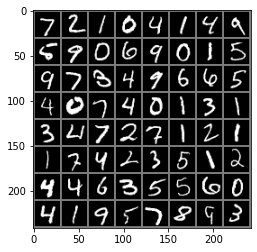

In [4]:
epoch_num = 20
batch_size = 64
device = 'cuda'

#设置训练集
mydataset = datasets.MNIST(root="data",
                           train=True,
                           download=True,
                           transform=transforms.Compose(
                               [
                                   transforms.ToTensor(),      
                                   transforms.Normalize((0.5,),(0.5,))
                               ]    #transfrom 将图片转化为-1到1的张量
                           ))
#设置测试集
mytestset = datasets.MNIST(root="data",
                            download=True,
                           train=False,
                           transform=transforms.Compose(
                               [
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,),(0.5,))
                               ]
                           ))

#数据装载操作
mydataloader = DataLoader(dataset=mydataset,
                          batch_size=batch_size,
                          shuffle=True)   #batch_size设置了每批装载的数据图片为64个（每次投喂的样本数量），shuffle设置为True在装载过程中为随机乱序
mytestloader = DataLoader(dataset=mytestset,
                          batch_size=batch_size)

test_data_iter = iter(mytestloader)
test_image, test_label = test_data_iter.next()

# ---------------------显示训练的图像-----------------------------------------
#需要改小batch的值
import matplotlib.pyplot as plt
import numpy as np
import torchvision

classes = ('0','1','2','3','4','5','6','7','8','9')

def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()
    
print(' '.join('%5s' % classes[test_label[j]] for j in range(batch_size)))

imshow(torchvision.utils.make_grid(test_image))
# ----------------------------------------------------------------------------

#使用GPU加速
mymodel = LowPrecisionLeNet().to(device) 

#优化 优化方法是 SGD， 第一个参数是模型的参数，第二个是学习率，第三个是动量
optimizer = optim.SGD(params=mymodel.parameters(),
                      lr=0.01,
                      momentum=0.9)

#调整学习率   调整倍数为gamma倍，调整间隔为step_size
scheduler = StepLR.StepLR(optimizer=optimizer,
                          step_size=1,
                          gamma=0.9)

# 训练神经网络


In [5]:
#训练流程：每次给模型输入一个batch的数据，batch怎么选？把数据集打乱，然后按照打乱后的数据生成
#一个batch的数据作为输入。
#对这一个batch所产生的loss进行对模型参数的梯度计算，然后更新模型参数。
#然后进行下一个batch的迭
#当遍历dataset里面全部数据的时候，就称完成了一个epoch
#FINNManager.export(low_precision_lenet, input_shape=(1,1,28,28), export_path='finn_lenet.onnx')  
#FINNManager.export(quartznet, QUARTZNET_POSTPROCESSED_INPUT_SIZE, finn_onnx)

for i in range(epoch_num):
    print('*********************Begin the {}th epoch************************'.format(i+1))
    loss_record = 0.
    #需要一个能否持续不断的给model输入一个batch数据的迭代器
    for idx,(data,label) in enumerate(mydataloader):
        optimizer.zero_grad()   #使用optimizer.zero_grad()手动将梯度设置为零，因为PyTorch在默认情况下会累积梯度
        data,label = data.to(device),label.to(device)
        output = mymodel(data)
        loss = F.nll_loss(output,label)   #计算输出（output）与真值标签（target）之间的负对数概率损失
        loss.backward()  #对损失反向传播
        optimizer.step()  # #收集一组新的梯度，并使用optimizer.step()将其传播回每个网络参数
        loss_record+=loss.item()
    print('The average loss of {}th epoch is {}'.format(i+1,loss_record/len(mydataloader)))
    correct = 0
    for idx,(data,label) in enumerate(mytestloader):
        data,label = data.to(device),label.to(device)
        output = mymodel(data)
        pred = output.argmax(dim=1, keepdim=True) # 预测概率最大的下标
        correct += pred.eq(label.view_as(pred)).sum().item()
    print('The accuracy of {}th epoch in test set is {}%'.format(i+1,100*correct/len(mytestset)))
    scheduler.step()
    
FINNManager.export(low_precision_lenet, input_shape=(1,1,28,28), export_path='finn_lenet.onnx')    # FINNManager.export(quartznet, QUARTZNET_POSTPROCESSED_INPUT_SIZE, finn_onnx)

*********************Begin the 1th epoch************************
The average loss of 1th epoch is 0.44051640183587415
The accuracy of 1th epoch in test set is 97.39%
*********************Begin the 2th epoch************************
The average loss of 2th epoch is 0.07503710490371436
The accuracy of 2th epoch in test set is 98.37%
*********************Begin the 3th epoch************************
The average loss of 3th epoch is 0.054966441319157275
The accuracy of 3th epoch in test set is 98.23%
*********************Begin the 4th epoch************************
The average loss of 4th epoch is 0.04231447556435487
The accuracy of 4th epoch in test set is 98.41%
*********************Begin the 5th epoch************************
The average loss of 5th epoch is 0.03427362823525001
The accuracy of 5th epoch in test set is 98.83%
*********************Begin the 6th epoch************************
The average loss of 6th epoch is 0.028977928269471574
The accuracy of 6th epoch in test set is 98.65%
**

ir_version: 6
producer_name: "pytorch"
producer_version: "1.7"
graph {
  node {
    input: "inp.1"
    input: "10"
    output: "11"
    name: "MultiThreshold_1"
    op_type: "MultiThreshold"
    attribute {
      name: "out_dtype"
      s: "INT4"
      type: STRING
    }
    domain: "finn.custom_op.general"
  }
  node {
    input: "11"
    input: "12"
    output: "13"
    name: "Add_3"
    op_type: "Add"
    domain: ""
  }
  node {
    input: "13"
    input: "14"
    output: "15"
    name: "Mul_5"
    op_type: "Mul"
  }
  node {
    input: "15"
    input: "16"
    output: "18"
    name: "Conv_8"
    op_type: "Conv"
    attribute {
      name: "dilations"
      ints: 1
      ints: 1
      type: INTS
    }
    attribute {
      name: "group"
      i: 1
      type: INT
    }
    attribute {
      name: "kernel_shape"
      ints: 5
      ints: 5
      type: INTS
    }
    attribute {
      name: "pads"
      ints: 2
      ints: 2
      ints: 2
      ints: 2
      type: INTS
    }
    attri

In [6]:
from finn.util.visualization import showInNetron
showInNetron('finn_lenet.onnx')

Serving 'finn_lenet.onnx' at http://0.0.0.0:8081


In [7]:
import finn.builder.build_dataflow as build
import finn.builder.build_dataflow_config as build_cfg

In [8]:
! cat {estimates_output_dir}/report/folding_config.json

cat: {estimates_output_dir}/report/folding_config.json: No such file or directory


In [ ]:
model_name = "tfc_w1a1"
platform_name = "fpga"

cfg = build.DataflowBuildConfig(
    board=platform_name,
    output_dir="output_%s_%s" % (model_name, platform_name),  #定义要为 FINN 编译器输出创建的目录。
    target_fps=100000,  #FINN 编译器要达到的预期吞吐量性能目标。
    mvau_wwidth_max=10000,  #用于说明如何将附加配置点传递给编译器。
    synth_clk_period_ns=10.0,
    #folding_config_file="folding_config.json", #一个可选参数，它指向定义所使用的层优化（PE、SIMD、ramstyle 等）的 json 文件。
    fpga_part="xqrku060-cna1509-1M-m",
    shell_flow_type=build_cfg.ShellFlowType.VIVADO_ZYNQ,
    generate_outputs=[
        build_cfg.DataflowOutputType.STITCHED_IP,
        #build_cfg.DataflowOutputType.PYNQ_DRIVER,
        #build_cfg.DataflowOutputType.RTLSIM_PERFORMANCE,
        #build_cfg.DataflowOutputType.ESTIMATE_REPORTS,
        #build_cfg.DataflowOutputType.OOC_SYNTH,
        #build_cfg.DataflowOutputType.DEPLOYMENT_PACKAGE,
    ],
    verify_steps=[
        build_cfg.VerificationStepType.TIDY_UP_PYTHON,
        build_cfg.VerificationStepType.STREAMLINED_PYTHON,
        build_cfg.VerificationStepType.FOLDED_HLS_CPPSIM,
        build_cfg.VerificationStepType.STITCHED_IP_RTLSIM,
    ],
    save_intermediate_models=True,
)
model_file = "finn_lenet.onnx" #设置量化模型的来源。
build.build_dataflow_cfg(model_file, cfg)

In [ ]:
mytestset = datasets.MNIST(root="data",
                            download=True,
                           train=False,
                           transform=transforms.Compose(
                               [
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,),(0.5,))
                               ]
                           ))


#mytestset_np = mytestset.numpy()

a = '';

for i in range(20):
    
    
    b = str(mytestset[i][0][0]).replace("tensor",'').replace("([[",'').replace(',','').replace('[','').replace(']','').replace("\n",'').replace(' ','').replace(')','')
    d = str(test_label[i]).replace("tensor",'').replace('(','').replace(')','')
    #print(d)
    #print(str(mytestset[i][0][0]))
    b = ''.join(format(ord(c), '02x') for c in b)
    d = 'ffffffffffffffffffffffffffffffffffffffffffffffffffffff'+''.join(format(ord(c),'02x') for c in d)
    #print(d)
    a = a + b+d
    
#c = 200;
#print('ffffffffffffffffffffffffffffffffffffffffffffffffffffff{:02X}'.format(c));
print(a);
    #print('ffffffffffffffffffffffffffffffffffffffffffffffffffffff{:02X}'.format(test_y[i]))

In [ ]:
def save_to_file(file_name,contents):
    fh = open(file_name,'w')
    fh.write(contents)
    fh.close()

In [ ]:
save_to_file("data.hex",a);

In [ ]:
! ls

model_file = "finn_lenet.onnx"
extimates_output_dir="output_tfc_w1a1_fpga"

In [ ]:
! ls {extimates_output_dir/report

In [ ]:
! cat {extimates_output_dir}/report/estimate_layer_resources_hls.json

In [ ]:
import json
def read_json_dict(filename):
    with open(filename, "r") as f:
        ret = json.load(f)
    return ret

In [ ]:
read_json_dict(estimates_output_dir + "/report/estimate_layer_cycles.json")